In [1]:
"""! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
! pip install nltk
! pip install pattern
! pip install wordcloud
! pip install gensim
! pip install xgboost
# ! python -m spacy download pt_core_news_sm
! python -m spacy download pt_core_news_lg"""

'! pip install datasets\n! pip install matplotlib\n! pip install scikit-learn\n! pip install spacy\n! pip install nltk\n! pip install pattern\n! pip install wordcloud\n! pip install gensim\n! pip install xgboost\n# ! python -m spacy download pt_core_news_sm\n! python -m spacy download pt_core_news_lg'

In [2]:
from sklearn.metrics import classification_report, f1_score, hamming_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from datasets import load_dataset
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import vstack
import pandas as pd
import numpy as np
import warnings
import spacy
import nltk
import re

nltk.download('stopwords')

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


/opt/anaconda3/envs/NLP_Ass1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martapereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Data Loading and Understanding**

In [3]:
dataset = load_dataset("higopires/RePro-categories-multilabel")

In [ ]:
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


Checking the missing values

In [7]:
train_data.isnull().sum()

review_text               0
ENTREGA                   0
OUTROS                    0
PRODUTO                   0
CONDICOESDERECEBIMENTO    0
INADEQUADA                0
ANUNCIO                   0
dtype: int64

Example of some reviews

In [8]:
print(train_data["review_text"][2])

Entrega rápida, produto muito bom Amei. Praticidade


In [9]:
print(train_data["review_text"][7])

...................     ..........gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg


In [10]:
# check data type of review_text
print(type(train_data["review_text"][0]))
# check data type of label PRODUTO
print(type(train_data["PRODUTO"][0]))

<class 'str'>
<class 'numpy.int64'>


In [ ]:
columns = list(dataset["train"].features.keys())
labels = columns[1:]  

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


In [ ]:
label_cols = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

## **EDA**

{'PRODUTO': 6258, 'ENTREGA': 2488, 'OUTROS': 1885, 'CONDICOESDERECEBIMENTO': 1369, 'ANUNCIO': 699, 'INADEQUADA': 328}


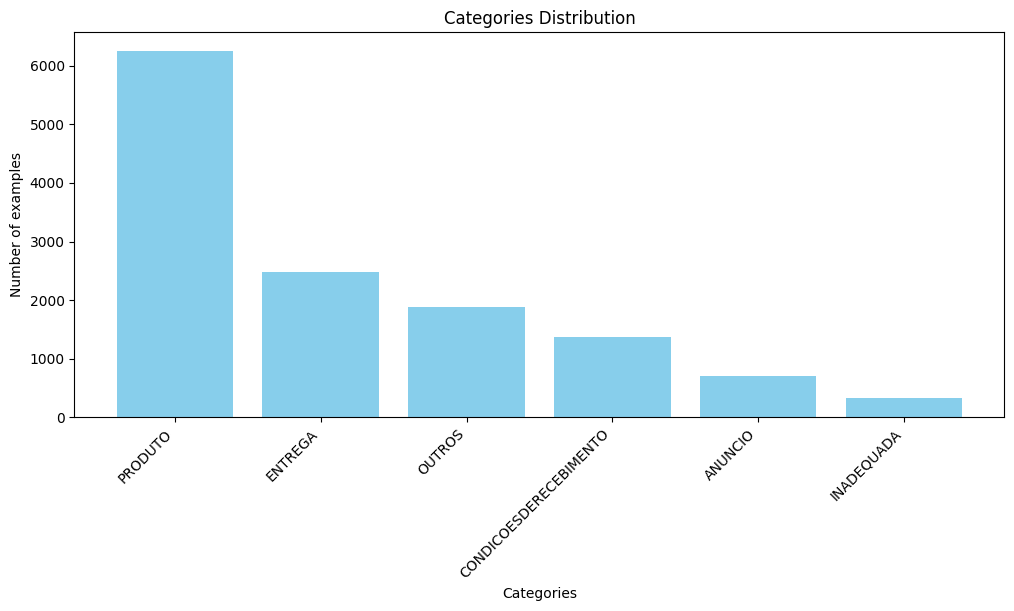

In [ ]:
label_counts = train_data.iloc[:, 1:].sum()

label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

print(label_counts)

plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

Number of labels per review distribution:
1    4188
2    2741
3     943
4     122
5       8
Name: count, dtype: int64


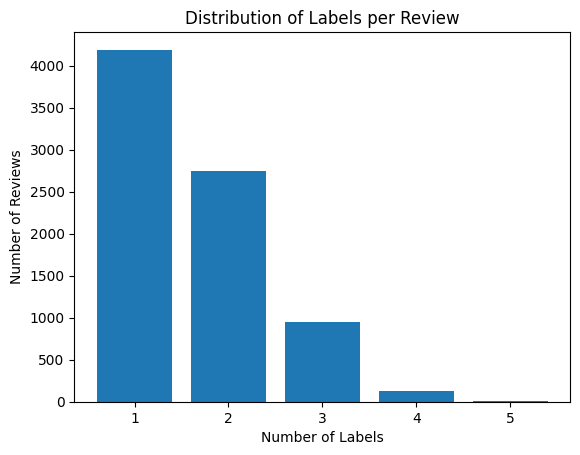

In [15]:
label_counts_per_review = train_data[label_cols].sum(axis=1)
print("Number of labels per review distribution:")
print(pd.Series(label_counts_per_review).value_counts())

plt.hist(label_counts_per_review, bins=range(1, 7), align='left', rwidth=0.8)
plt.title("Distribution of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Reviews")
plt.show()

* 4188 reviews have exactly 1 label
* 2741 reviews have exactly 2 labels
* 943 reviews have exactly 3 labels
* 122 reviews have exactly 4 labels
* 8 reviews have exactly 5 labels

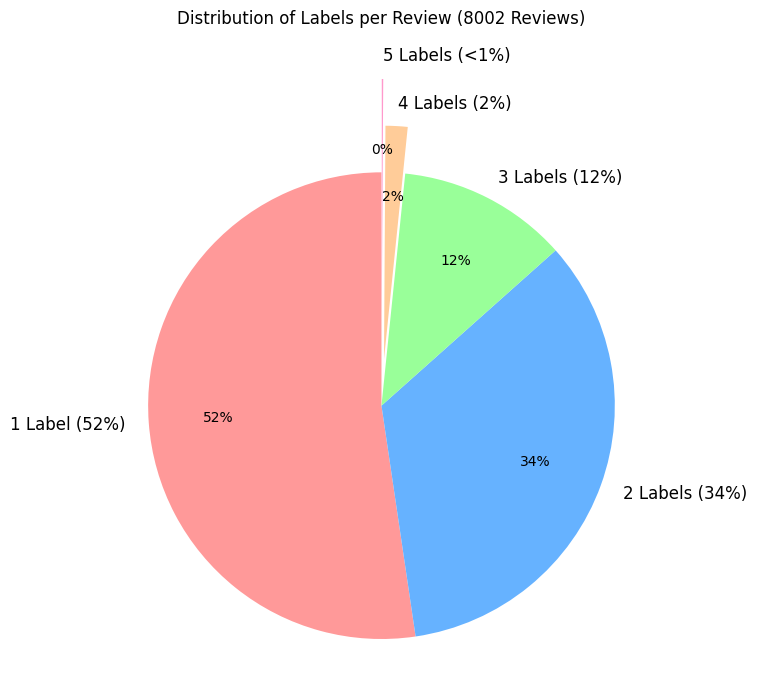

In [ ]:
label_counts = label_counts_per_review.value_counts().values
total_reviews = 8002
percentages = [count / total_reviews * 100 for count in label_counts]
labels = ['1 Label (52%)', '2 Labels (34%)', '3 Labels (12%)', '4 Labels (2%)', '5 Labels (<1%)']


plt.figure(figsize=(8, 8))

explode = [0, 0, 0, 0.2, 0.4] 
wedges, texts, autotexts = plt.pie(percentages, labels=labels, autopct='%1.0f%%', startangle=90,
                                   colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'],
                                   explode=explode, labeldistance=1.1, pctdistance=0.7)

for text in texts:
    text.set_fontsize(12) 
for autotext in autotexts:
    autotext.set_fontsize(10)  
    autotext.set_color('black')  

plt.title("Distribution of Labels per Review (8002 Reviews)", pad=20)
plt.axis('equal') 
plt.show()

In [17]:
text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Maximum text length: {np.max(text_lengths)} words")
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


Raw Vocabulary Size: 12742
Most Common Words: [('o', 7032), ('e', 6464), ('a', 5831), ('de', 5458), ('não', 4924), ('produto', 4296), ('que', 4200), ('é', 3167), ('muito', 2923), ('com', 2743), ('do', 2700), ('um', 2196), ('para', 2114), ('no', 1504), ('da', 1501), ('mas', 1429), ('bom', 1426), ('em', 1342), ('na', 1325), ('entrega', 1306)]
Example of Rare Words: ['aquisitivo', 'gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg', 'genero', 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx', 'constatada', 'habilitada', 'opnar', 'oproduto', 'ceição', 'soares']


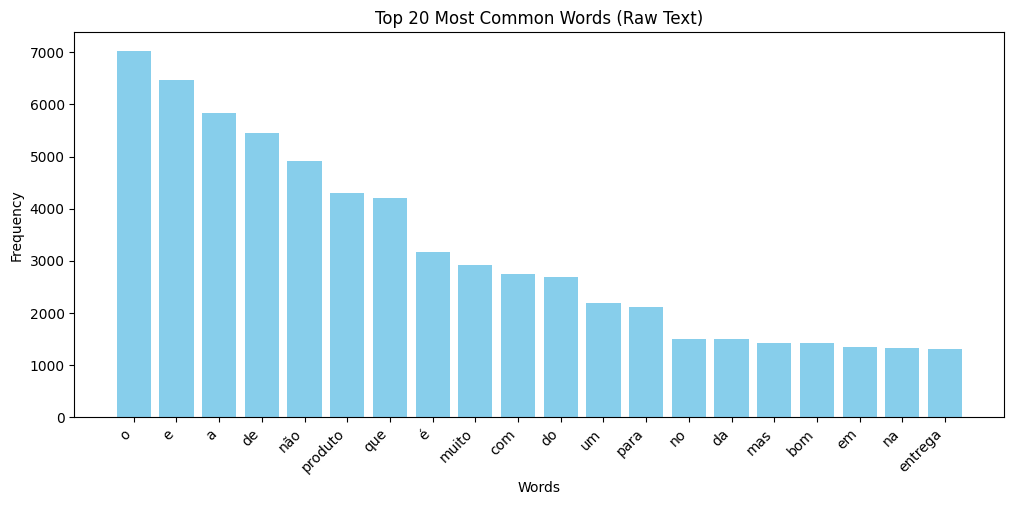

In [ ]:
# Tokenize words from raw reviews
raw_texts = " ".join(train_data["review_text"]).lower()
raw_tokens = re.findall(r'\b\w+\b', raw_texts)  
raw_vocab_size = len(set(raw_tokens)) 
raw_word_counts = Counter(raw_tokens)

common_raw_words = raw_word_counts.most_common(20)

rare_raw_words = [word for word, count in raw_word_counts.items() if count == 1]

print(f"Raw Vocabulary Size: {raw_vocab_size}")
print(f"Most Common Words: {common_raw_words}")
print(f"Example of Rare Words: {rare_raw_words[:10]}")

plt.figure(figsize=(12, 5))
plt.bar([word for word, count in common_raw_words], [count for word, count in common_raw_words], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words (Raw Text)")
plt.show()

## **Preprocessing**

In [ ]:
nlp = spacy.load('pt_core_news_lg')

stemmer = SnowballStemmer("portuguese")

def preprocess_text(text, method="lemma"):
    """
    Preprocess text by applying lemmatization or stemming.

    Parameters:
    - text (str): Input text
    - method (str): "lemma" for lemmatization, "stem" for stemming

    Returns:
    - str: Preprocessed text
    """
   
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    doc = nlp(text)

    if method == "lemma":
        tokens = [token.lemma_ for token in doc if not token.is_stop]
    elif method == "stem":
        tokens = [stemmer.stem(token.text) for token in doc if not token.is_stop]
    else:
        raise ValueError("Method must be 'lemma' or 'stem'")

    return ' '.join(tokens)

train_data['lemmatized_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
train_data['stemmed_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

val_data['lemmatized_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
val_data['stemmed_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

test_data['lemmatized_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
test_data['stemmed_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))


In [20]:
print("Original:", train_data['review_text'].iloc[0])
print("Lemmatized:", train_data['lemmatized_reviews'].iloc[0])
print("Stemmed:", train_data['stemmed_reviews'].iloc[0])

Original: Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!
Lemmatized: aparelho confiável aquisitivo conta ser massa precisar
Stemmed: aparelh confiável aquisit cont sej mass precis


In [21]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO,lemmatized_reviews,stemmed_reviews
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0,aparelho confiável aquisitivo conta ser massa ...,aparelh confiável aquisit cont sej mass precis
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0,história autor enrolar livro,histór autor enrol livr
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0,entregar rápido produto amar praticidade,entreg ráp produt ame pratic
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0,produto otimo so carregador maquina pequeno,produt otim so carreg maquin pequen
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0,proteção anti queda cair frente tela,proteçã anti qued cair frent tel


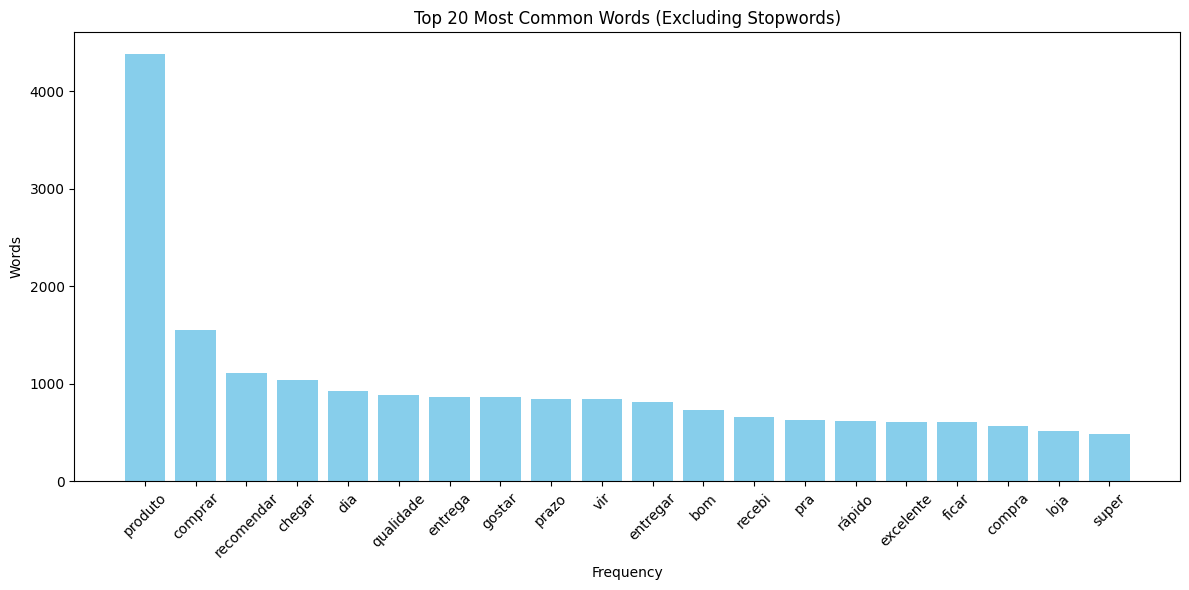

In [ ]:
all_words = " ".join(train_data["lemmatized_reviews"]).split()

word_counts = Counter(all_words)

most_common_words = word_counts.most_common(20)

word_most_common_df = pd.DataFrame(most_common_words, columns=["Word", "Count"])


plt.figure(figsize=(12, 6))
plt.bar(word_most_common_df["Word"], word_most_common_df["Count"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words (Excluding Stopwords)")
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

In [ ]:
less_common_words = word_counts.most_common()[:-21:-1]

word_less_common_df = pd.DataFrame(less_common_words, columns=["Word", "Count"])

print(word_less_common_df)

words_appear_once = [word for word, count in word_counts.items() if count == 1]
print(f"Number of words that appear only once: {len(words_appear_once)}")

                                                 Word  Count
0                                                  ni      1
1                                          compátivel      1
2                                           chinamate      1
3                                     compraaquisição      1
4                                               grife      1
5                                              prazoe      1
6                                   confortávelbonito      1
7                                                Cabo      1
8                                        excelentepor      1
9   anunciadokkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...      1
10                                               conf      1
11                                              penso      1
12                                        instalausar      1
13                                            robusta      1
14                                         outramuito      1
15                      

In [ ]:
vocab_size = len(set(all_words))  

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9957


Part Of Speech (POS) serves to identify nouns, verbs, etc., and filtered to keep only certain POS tags (e.g., nouns) before feature extraction. We didn't apply POS, because lemmatization already simplifies terms and multi-label needs flexible features (not just nouns or adjectives), so this technique might be redundant.

## **Feature Extraction**

## **1- TF-IDF**

### **1.1- Unigram TF-IDF Vectorization**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'])
X_val_tfidf = tfidf_vectorizer.transform(val_data['lemmatized_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'])

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 488.2262
recomendar: 234.1057
chegar: 203.3263
comprar: 199.9689
prazo: 194.0114
qualidade: 185.3566
gostar: 182.2771
entregar: 181.8631
entrega: 173.2043
rápido: 154.2068
excelente: 151.3629
bom: 146.1159
dia: 143.8600
recebi: 136.4783
vir: 136.1746
super: 119.6697
ótimo: 114.8176
atender: 106.3468
compra: 105.3768
pra: 98.0093


### **1.2- Bigram TF-IDF Vectorization**

In [ ]:
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams

X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['lemmatized_reviews'])
X_val_tfidf_bi = tfidf_bigram.transform(val_data['lemmatized_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['lemmatized_reviews'])

tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
feature_names_bi = tfidf_bigram.get_feature_names_out()
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

print("\nTop 20 bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 bigrams by TF-IDF score:
recebi produto: 55.4152
chegar prazo: 55.0975
produto chegar: 49.3651
gostar produto: 47.2966
entregar prazo: 47.2189
produto entregar: 41.0208
atender expectativa: 37.7258
ótimo qualidade: 37.1043
produto excelente: 34.6375
bom produto: 33.2058
produto qualidade: 32.6299
produto ótimo: 32.1825
excelente produto: 30.1993
entregar rápido: 29.5193
super recomendar: 29.4634
produto atender: 28.9780
produto vir: 28.8988
super rápido: 28.6211
valer pena: 28.4338
comprar produto: 27.4269


### **1.3- Unigram + Bigram TF-IDF Vectorization**

In [ ]:
def create_tfidf_features_uni_bi(train_texts, val_texts, test_texts, min_df=1, max_features=None):
    """
    Generate TF-IDF features with specified min_df and max_features.
    
    Parameters:
    - train_texts: Training data (e.g., train_data['lemmatized_reviews'])
    - val_texts: Validation data (e.g., val_data['lemmatized_reviews'])
    - test_texts: Test data (e.g., test_data['lemmatized_reviews'])
    - min_df: Minimum document frequency (default=2)
    - max_features: Maximum number of features (default=None, no limit)
    
    Returns:
    - X_train_tfidf, X_val_tfidf, X_test_tfidf: TF-IDF matrices
    - feature_names: List of feature names
    """
    tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=min_df, max_features=max_features)
    
    X_train_tfidf = tfidf.fit_transform(train_texts)
    X_val_tfidf = tfidf.transform(val_texts)
    X_test_tfidf = tfidf.transform(test_texts)
    
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()
    word_tfidf_scores = dict(zip(feature_names, tfidf_scores))
    sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    
    
    print(f"Feature space size: {X_train_tfidf.shape[1]}")
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, feature_names, sorted_words[:20]

X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,  
    max_features=5000  
)

print(f"\nTop 20 unigrams + bigrams by TF-IDF score")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Feature space size: 5000

Top 20 unigrams + bigrams by TF-IDF score
produto: 397.9442
recomendar: 184.9531
comprar: 181.4826
chegar: 162.0091
gostar: 155.7969
qualidade: 146.8700
prazo: 144.8143
entregar: 140.2032
entrega: 133.6801
bom: 124.6411
dia: 122.2652
vir: 121.7276
excelente: 117.9173
rápido: 116.5107
recebi: 114.0214
super: 95.8461
pra: 91.9058
ficar: 89.7605
ótimo: 89.1564
atender: 87.7731


There's only single words in the top 20 TF-IDF scores for unigrams + bigrams, because the unigrams have higher TF-IDF scores compared to the bigrams. This can happen if the unigrams are more frequent or carry more weight in the dataset.

#### Why unigrams + bigrams? 
Unigrams capture individual word importance, while bigrams preserve some context (e.g., "não entregue" might indicate a delivery issue better than "não" or "entregue" alone). Since reviews are short (avg. 24.58 words), bigrams add value without overwhelming the feature space.

For word distribution, we choose TF-IDF with unigrams + bigrams (ngram_range=(1, 2), 5000 features) as it captures both dominant single words (e.g., "produto": 397.94) and contextual phrases (e.g., "chegar prazo") in the RePro dataset. This reflects the mix of 52% single-label and 48% multi-label reviews, providing a comprehensive view of key terms without relying on model performance.

In [28]:
label_names = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

y_train = train_data[label_names].to_numpy()
y_val = val_data[label_names].to_numpy()
y_test = test_data[label_names].to_numpy()
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8002, 6)
y_val shape: (994, 6)
y_test shape: (1007, 6)


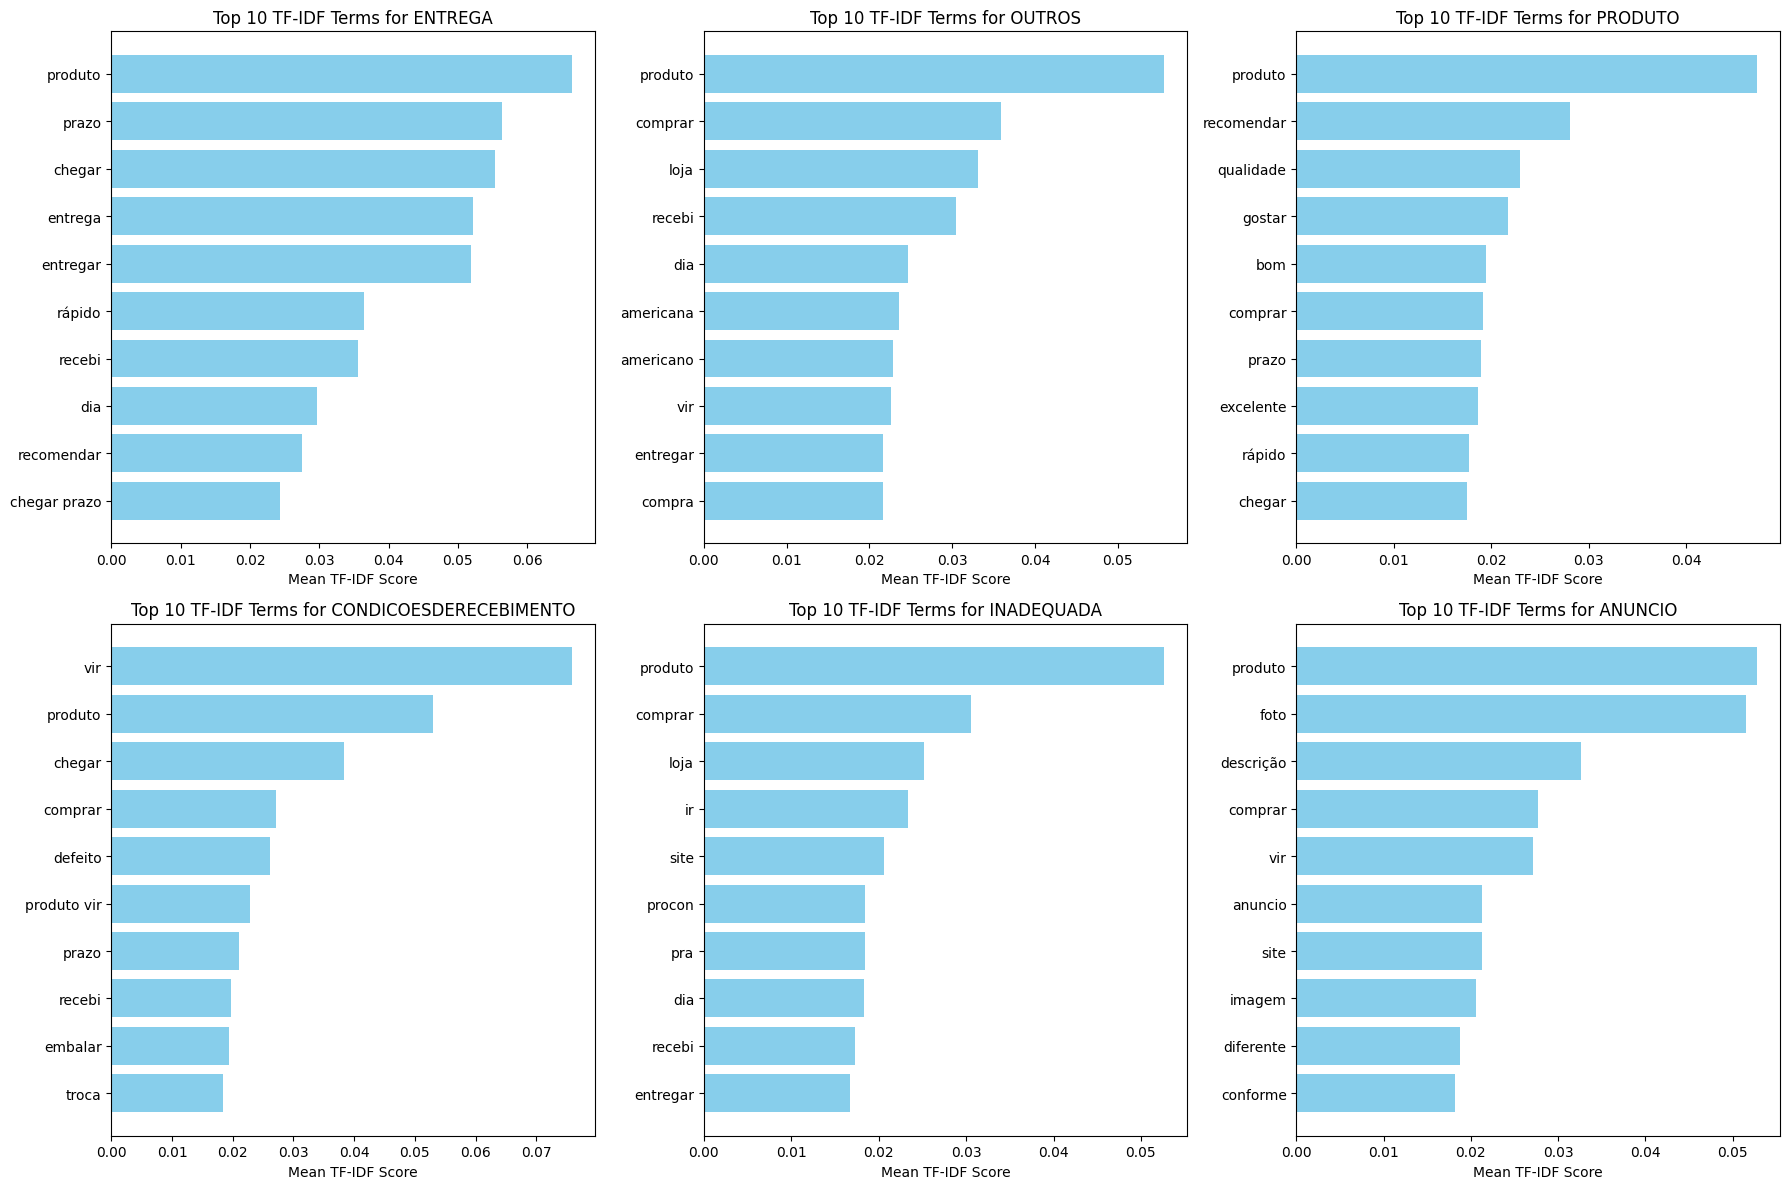

In [ ]:
n_top = 10  
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  
axes = axes.flatten()

for i, label in enumerate(label_names):
    label_indices = np.where(y_train[:, i] == 1)[0]
    label_tfidf = X_train_tfidf_bi[label_indices].mean(axis=0).A1  
    top_indices = np.argsort(label_tfidf)[-n_top:][::-1] 
    top_terms = feature_names_bi[top_indices]
    top_scores = label_tfidf[top_indices]

    axes[i].barh(top_terms, top_scores, color='skyblue')
    axes[i].set_title(f'Top {n_top} TF-IDF Terms for {label}')
    axes[i].set_xlabel('Mean TF-IDF Score')
    axes[i].invert_yaxis()  

plt.tight_layout()
plt.show()

### Feature Space

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 9824


In [31]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 59291


In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 69115


In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Unigrams and bigrams only keeping the terms that occur more than 2 times
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 11400


In [34]:
vectorizer = TfidfVectorizer(max_features=10000 ,ngram_range=(1, 2))  # Unigrams and bigrams with maximum number of features
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 10000


## **2- Word2Vec**

In [ ]:
def tokenize(text):
    doc = nlp(text)
    return [token.text.lower() for token in doc if not token.is_stop and token.is_alpha]

train_tokens = [tokenize(text) for text in train_data["review_text"]]

w2v_model = Word2Vec(sentences=train_tokens, vector_size=300, window=5, min_count=1, workers=4)

def get_w2v_vector(text, model):
    tokens = tokenize(text)
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

X_train_w2v = np.array([get_w2v_vector(text, w2v_model) for text in train_data["review_text"]])
X_val_w2v = np.array([get_w2v_vector(text, w2v_model) for text in val_data["review_text"]])

print("Word2Vec features:")
print("Training data:", X_train_w2v[:10])

Word2Vec features:
Training data: [[-0.13427222  0.22447206  0.05044617 ... -0.10533496  0.20189087
  -0.05339441]
 [-0.06538165  0.11131394  0.02368169 ... -0.04989835  0.09867778
  -0.02630302]
 [-0.13461423  0.34109533  0.0485317  ... -0.14144036  0.27593276
  -0.10718279]
 ...
 [-0.00128908 -0.00131401 -0.00294971 ... -0.00229093  0.00322753
  -0.00061842]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [36]:
print(X_train_tfidf_bi.shape)
print(X_train_w2v.shape)

(8002, 5000)
(8002, 300)


## **3-Combination of TF-IDF with Word2Vec**

In [37]:
def combine_tfidf_w2v(tfidf_matrix, w2v_matrix, method="concat"):
    """
    Combine TF-IDF and Word2Vec features.
    
    Parameters:
    - tfidf_matrix: TF-IDF feature matrix (sparse or dense)
    - w2v_matrix: Word2Vec feature matrix (dense)
    - method: "concat" for simple concatenation, "weighted" for TF-IDF-weighted Word2Vec
    
    Returns:
    - Combined feature matrix
    """
    if method == "concat":
        tfidf_matrix = tfidf_matrix.toarray()
        return np.hstack((tfidf_matrix, w2v_matrix))
    else:
        raise ValueError("Method must be 'concat' or 'weighted'")

X_train_combined = combine_tfidf_w2v(X_train_tfidf_bi, X_train_w2v, method="concat")
X_val_combined = combine_tfidf_w2v(X_val_tfidf_bi, X_val_w2v, method="concat")

print("Combined feature shape (train):", X_train_combined.shape)  # (8002, 5300) = 5000 TF-IDF + 300 W2V
print("Combined feature shape (val):", X_val_combined.shape)

Combined feature shape (train): (8002, 5300)
Combined feature shape (val): (994, 5300)


## **Models Training and Evaluation**

In [ ]:
def evaluate_baseline(X_train, X_val, y_train, y_val, label_names, config_name):
    baseline_clf = OneVsRestClassifier(MultinomialNB())
    baseline_clf.fit(X_train, y_train)
    y_pred = baseline_clf.predict(X_val)
    
    print(f"\n=== Baseline Results for {config_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming_value = hamming_loss(y_val, y_pred)
    
    print("\nMétricas Gerais:")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming_value:.4f}")
    return macro_f1, micro_f1, hamming_value

def evaluate_model(X_train, X_val, y_train, y_val, model_name, classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    
    print(f"\n=== {model_name} ===")
    print("Relatório de Classificação por Rótulo:")
    print(classification_report(y_val, y_pred, target_names=label_names))
    
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    micro_f1 = f1_score(y_val, y_pred, average='micro')
    hamming_value = hamming_loss(y_val, y_pred)
    
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Hamming Loss: {hamming_value:.4f}")
    return macro_f1, micro_f1, hamming_value, y_pred

### Baseline Classifier - Naive Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

configs = [
    {'min_df': 1, 'max_features': None, 'name': 'original'},
    {'min_df': 2, 'max_features': None, 'name': 'min_df=2 -> features = 11400'},
    {'min_df': 3, 'max_features': None, 'name': 'min_df=3 -> features = 6142'},
    {'min_df': 1, 'max_features': 7000, 'name': 'max_features=7000'},
    {'min_df': 1, 'max_features': 5000, 'name': 'max_features=5000'}
]

results = {}

for config in configs:
    min_df = config['min_df']
    max_features = config['max_features']
    config_name = config['name']
    
    tfidf_result = create_tfidf_features_uni_bi(
        train_data['lemmatized_reviews'],
        val_data['lemmatized_reviews'],
        test_data['lemmatized_reviews'],
        min_df=min_df,
        max_features=max_features
    )
    
    X_train_tfidf_bi, X_val_tfidf_bi, X_test_tfidf_bi, feature_names_bi, sorted_words = tfidf_result
    
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_tfidf_bi, X_val_tfidf_bi, y_train, y_val, label_names, config_name
    )
    
    results[f"{config_name}(TF-IDF)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}

    X_train_w2v = np.array([get_w2v_vector(text, w2v_model) for text in train_data['lemmatized_reviews']])
    X_val_w2v = np.array([get_w2v_vector(text, w2v_model) for text in val_data['lemmatized_reviews']])
    X_test_w2v = np.array([get_w2v_vector(text, w2v_model) for text in test_data['lemmatized_reviews']])
    
    scaler = MinMaxScaler()
    X_train_w2v = scaler.fit_transform(X_train_w2v)
    X_val_w2v = scaler.transform(X_val_w2v)
    X_test_w2v = scaler.transform(X_test_w2v)

    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_w2v, X_val_w2v, y_train, y_val, label_names, f"{config_name} (Word2Vec)"
    )
    
    results[f"{config_name} (Word2Vec)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}
    
    X_train_combined = combine_tfidf_w2v(X_train_tfidf_bi, X_train_w2v, method="concat")
    X_val_combined = combine_tfidf_w2v(X_val_tfidf_bi, X_val_w2v, method="concat")
    X_test_combined = combine_tfidf_w2v(X_test_tfidf_bi, X_test_w2v, method="concat")
    
    macro_f1, micro_f1, hamming = evaluate_baseline(
        X_train_combined, X_val_combined, y_train, y_val, label_names, f"{config_name} (TF-IDF + Word2Vec)"
    )
    
    results[f"{config_name}(TF-IDF + Word2Vec)"] = {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'hamming_loss': hamming}

print("\n=== Summary of Baseline Results ===")
for config_name, metrics in results.items():
    print(f"{config_name}: Macro F1={metrics['macro_f1']:.4f}, Micro F1={metrics['micro_f1']:.4f}, Hamming Loss={metrics['hamming_loss']:.4f}")

Feature space size: 69115

=== Baseline Results for original ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.97      0.68      0.80       311
                OUTROS       0.95      0.17      0.29       235
               PRODUTO       0.82      1.00      0.90       782
CONDICOESDERECEBIMENTO       1.00      0.01      0.01       171
            INADEQUADA       0.00      0.00      0.00        42
               ANUNCIO       0.00      0.00      0.00        88

             micro avg       0.85      0.63      0.73      1629
             macro avg       0.62      0.31      0.33      1629
          weighted avg       0.82      0.63      0.63      1629
           samples avg       0.85      0.72      0.76      1629


Métricas Gerais:
Macro F1: 0.3336
Micro F1: 0.7264
Hamming Loss: 0.1306

=== Baseline Results for original (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        pre

### Other classifiers
##### 1. Fine-tuned Logistic Regression
* TF-IDF

In [ ]:
C_values = [0.01, 0.1, 1.0, 10.0]
results = {}
train_results = [] 

for C in C_values:
    model_logreg = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
        ('Logistic Regression', OneVsRestClassifier(LogisticRegression(
            C=C, max_iter=1000, random_state=42, class_weight='balanced')))
    ])
    
    macro_f1, micro_f1, hamming, _ = evaluate_model(
        train_data['lemmatized_reviews'],  
        val_data['lemmatized_reviews'],    
        y_train,
        y_val,
        f"Logistic Regression (TF-IDF, C={C})",
        model_logreg
    )
    
    results[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C = max(results, key=lambda x: results[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'TF-IDF',
    'Macro F1': results[best_C]['Macro F1'],
    'Micro F1': results[best_C]['Micro F1'],
    'Hamming Loss': results[best_C]['Hamming Loss']
})

print(f"\n=== Best C Value ===")
print(f"Best C: {best_C} with Macro F1={results[best_C]['Macro F1']:.4f}, "
      f"Micro F1={results[best_C]['Micro F1']:.4f}, Hamming Loss={results[best_C]['Hamming Loss']:.4f}")


=== Logistic Regression (TF-IDF, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.85      0.88       311
                OUTROS       0.67      0.71      0.69       235
               PRODUTO       0.93      0.91      0.92       782
CONDICOESDERECEBIMENTO       0.69      0.71      0.70       171
            INADEQUADA       0.17      0.69      0.27        42
               ANUNCIO       0.74      0.82      0.78        88

             micro avg       0.78      0.84      0.81      1629
             macro avg       0.68      0.78      0.70      1629
          weighted avg       0.83      0.84      0.83      1629
           samples avg       0.83      0.87      0.83      1629

Macro F1: 0.7045
Micro F1: 0.8059
Hamming Loss: 0.1102

=== Logistic Regression (TF-IDF, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

    

* Word2Vec

In [ ]:
C_values = [0.01, 0.1, 1.0, 10.0]
results_w2v_logreg = {}
for C in C_values:
    model_logreg_w2v = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, 
                                                 f"Logistic Regression (Word2Vec, C={C})", model_logreg_w2v)
    results_w2v_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_w2v = max(results_w2v_logreg, key=lambda x: results_w2v_logreg[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'Word2Vec',
    'Macro F1': results_w2v_logreg[best_C_w2v]['Macro F1'],
    'Micro F1': results_w2v_logreg[best_C_w2v]['Micro F1'],
    'Hamming Loss': results_w2v_logreg[best_C_w2v]['Hamming Loss']
})

print(f"\n=== Best C Value (Word2Vec) ===")
print(f"Best C: {best_C_w2v} with Macro F1={results_w2v_logreg[best_C_w2v]['Macro F1']:.4f}, "
      f"Micro F1={results_w2v_logreg[best_C_w2v]['Micro F1']:.4f}, Hamming Loss={results_w2v_logreg[best_C_w2v]['Hamming Loss']:.4f}")



=== Logistic Regression (Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.57      0.74      0.64       311
                OUTROS       0.44      0.63      0.52       235
               PRODUTO       0.91      0.81      0.86       782
CONDICOESDERECEBIMENTO       0.26      0.61      0.36       171
            INADEQUADA       0.05      0.40      0.09        42
               ANUNCIO       0.12      0.74      0.21        88

             micro avg       0.44      0.74      0.55      1629
             macro avg       0.39      0.66      0.45      1629
          weighted avg       0.64      0.74      0.66      1629
           samples avg       0.50      0.77      0.57      1629

Macro F1: 0.4468
Micro F1: 0.5532
Hamming Loss: 0.3244

=== Logistic Regression (Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support



* Combination

In [ ]:
results_combined_logreg = {}
for C in C_values:
    model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=C, max_iter=1000, random_state=42, class_weight='balanced'))
    macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, 
                                                 f"Logistic Regression (TF-IDF + Word2Vec, C={C})", model_logreg_combined)
    results_combined_logreg[C] = {'Macro F1': macro_f1, 'Micro F1': micro_f1, 'Hamming Loss': hamming}

best_C_combined = max(results_combined_logreg, key=lambda x: results_combined_logreg[x]['Macro F1'])

train_results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': results_combined_logreg[best_C_combined]['Macro F1'],
    'Micro F1': results_combined_logreg[best_C_combined]['Micro F1'],
    'Hamming Loss': results_combined_logreg[best_C_combined]['Hamming Loss']
})

print(f"\n=== Best C Value (TF-IDF + Word2Vec) ===")
print(f"Best C: {best_C_combined} with Macro F1={results_combined_logreg[best_C_combined]['Macro F1']:.4f}, "
      f"Micro F1={results_combined_logreg[best_C_combined]['Micro F1']:.4f}, Hamming Loss={results_combined_logreg[best_C_combined]['Hamming Loss']:.4f}")



=== Logistic Regression (TF-IDF + Word2Vec, C=0.01) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.61      0.78      0.68       311
                OUTROS       0.49      0.66      0.56       235
               PRODUTO       0.91      0.85      0.88       782
CONDICOESDERECEBIMENTO       0.39      0.73      0.51       171
            INADEQUADA       0.06      0.38      0.10        42
               ANUNCIO       0.22      0.84      0.34        88

             micro avg       0.54      0.78      0.64      1629
             macro avg       0.45      0.71      0.51      1629
          weighted avg       0.68      0.78      0.71      1629
           samples avg       0.60      0.81      0.65      1629

Macro F1: 0.5127
Micro F1: 0.6354
Hamming Loss: 0.2450

=== Logistic Regression (TF-IDF + Word2Vec, C=0.1) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1

##### 2. Linear Support Vector Classification (SVC)

* TF-IDF

In [ ]:
model_svc = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

macro_f1, micro_f1, hamming, _ = evaluate_model(
    train_data['lemmatized_reviews'],  
    val_data['lemmatized_reviews'],    
    y_train,
    y_val,
    "SVM (TF-IDF)",
    model_svc
)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.95      0.93       311
                OUTROS       0.74      0.77      0.76       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.73      0.72      0.72       171
            INADEQUADA       0.19      0.33      0.24        42
               ANUNCIO       0.76      0.78      0.77        88

             micro avg       0.84      0.86      0.85      1629
             macro avg       0.71      0.75      0.72      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.87      0.89      0.86      1629

Macro F1: 0.7248
Micro F1: 0.8485
Hamming Loss: 0.0835


* Word2Vec

In [ ]:
model_svc_w2v = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "SVM (Word2Vec)", model_svc_w2v)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.82      0.84      0.83       311
                OUTROS       0.55      0.74      0.63       235
               PRODUTO       0.93      0.85      0.89       782
CONDICOESDERECEBIMENTO       0.41      0.74      0.53       171
            INADEQUADA       0.08      0.60      0.14        42
               ANUNCIO       0.21      0.77      0.33        88

             micro avg       0.58      0.81      0.67      1629
             macro avg       0.50      0.76      0.56      1629
          weighted avg       0.74      0.81      0.75      1629
           samples avg       0.65      0.84      0.70      1629

Macro F1: 0.5589
Micro F1: 0.6740
Hamming Loss: 0.2150


* Combination

In [ ]:
model_svc_combined = OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced'))
macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "SVM (TF-IDF + Word2Vec)", model_svc_combined)

train_results.append({
    'Model': 'SVM',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.91      0.95      0.93       311
                OUTROS       0.73      0.78      0.76       235
               PRODUTO       0.94      0.91      0.93       782
CONDICOESDERECEBIMENTO       0.74      0.72      0.73       171
            INADEQUADA       0.27      0.38      0.32        42
               ANUNCIO       0.77      0.78      0.78        88

             micro avg       0.85      0.86      0.85      1629
             macro avg       0.73      0.75      0.74      1629
          weighted avg       0.86      0.86      0.86      1629
           samples avg       0.88      0.89      0.86      1629

Macro F1: 0.7388
Micro F1: 0.8544
Hamming Loss: 0.0800


##### 3. XGBoost

In [ ]:
def compute_scale_pos_weight(y_train):
    n_samples, n_classes = y_train.shape
    scale_pos_weights = []
    for i in range(n_classes):
        pos_count = np.sum(y_train[:, i])
        neg_count = n_samples - pos_count
        if pos_count > 0:  
            scale_pos_weights.append(neg_count / pos_count)
        else:
            scale_pos_weights.append(1.0)  
    return scale_pos_weights

In [ ]:
class CustomXGBClassifier:
    def __init__(self, scale_pos_weights, **kwargs):
        self.scale_pos_weights = scale_pos_weights  
        self.kwargs = kwargs  
        self.estimators_ = []  

    def fit(self, X, y):
        self.estimators_ = []
        for i in range(y.shape[1]):  
            xgb = XGBClassifier(
                scale_pos_weight=self.scale_pos_weights[i],  
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='logloss',
                **self.kwargs 
            )
            xgb.fit(X, y[:, i])  
            self.estimators_.append(xgb)
        return self

    def predict(self, X):
        # Stack predictions for all labels
        predictions = np.array([est.predict(X) for est in self.estimators_]).T
        return predictions

    def predict_proba(self, X):
        # Stack probabilities (positive class) for all labels
        probas = np.array([est.predict_proba(X)[:, 1] for est in self.estimators_]).T
        return probas

* TF-IDF

In [ ]:
scale_pos_weights = compute_scale_pos_weight(y_train)

model_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)),
    ('XGBoost', CustomXGBClassifier(scale_pos_weights=scale_pos_weights))
])

macro_f1, micro_f1, hamming, _ = evaluate_model(
    train_data['lemmatized_reviews'],  
    val_data['lemmatized_reviews'],  
    y_train,
    y_val,
    "XGBoost (TF-IDF)",
    model_xgb
)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.93      0.91       311
                OUTROS       0.76      0.72      0.74       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.71      0.77      0.74       171
            INADEQUADA       0.11      0.43      0.17        42
               ANUNCIO       0.78      0.83      0.81        88

             micro avg       0.79      0.83      0.81      1629
             macro avg       0.70      0.76      0.71      1629
          weighted avg       0.85      0.83      0.84      1629
           samples avg       0.82      0.86      0.82      1629

Macro F1: 0.7100
Micro F1: 0.8104
Hamming Loss: 0.1065


* Word2Vec

In [49]:
model_xgb_w2v = CustomXGBClassifier(scale_pos_weights=scale_pos_weights)

macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_w2v, X_val_w2v, y_train, y_val, "XGBoost (Word2Vec)", model_xgb_w2v)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.78      0.82      0.80       311
                OUTROS       0.57      0.68      0.62       235
               PRODUTO       0.92      0.86      0.89       782
CONDICOESDERECEBIMENTO       0.38      0.57      0.46       171
            INADEQUADA       0.17      0.17      0.17        42
               ANUNCIO       0.21      0.33      0.26        88

             micro avg       0.69      0.75      0.72      1629
             macro avg       0.51      0.57      0.53      1629
          weighted avg       0.73      0.75      0.74      1629
           samples avg       0.75      0.79      0.74      1629

Macro F1: 0.5323
Micro F1: 0.7189
Hamming Loss: 0.1605


* Combination

In [ ]:
model_xgb_combined = CustomXGBClassifier(scale_pos_weights=scale_pos_weights)

macro_f1, micro_f1, hamming, _ = evaluate_model(X_train_combined, X_val_combined, y_train, y_val, "XGBoost (TF-IDF + Word2Vec)", model_xgb_combined)

train_results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.89      0.93      0.91       311
                OUTROS       0.69      0.77      0.73       235
               PRODUTO       0.93      0.86      0.90       782
CONDICOESDERECEBIMENTO       0.70      0.74      0.72       171
            INADEQUADA       0.27      0.40      0.33        42
               ANUNCIO       0.78      0.82      0.80        88

             micro avg       0.83      0.83      0.83      1629
             macro avg       0.71      0.75      0.73      1629
          weighted avg       0.84      0.83      0.84      1629
           samples avg       0.85      0.85      0.83      1629

Macro F1: 0.7308
Micro F1: 0.8314
Hamming Loss: 0.0924


The Combination of TF-IDF and Word2Vec is generally the best choice for most models, as it leverages the strengths of both feature sets. For the XGBoost classifier, we decided to choose the combination, that is the best, and TF-IDF even though does not achieve the highest Macro F1, it performs well in Micro F1 and Hamming Loss, making it a good candidate for comparison.

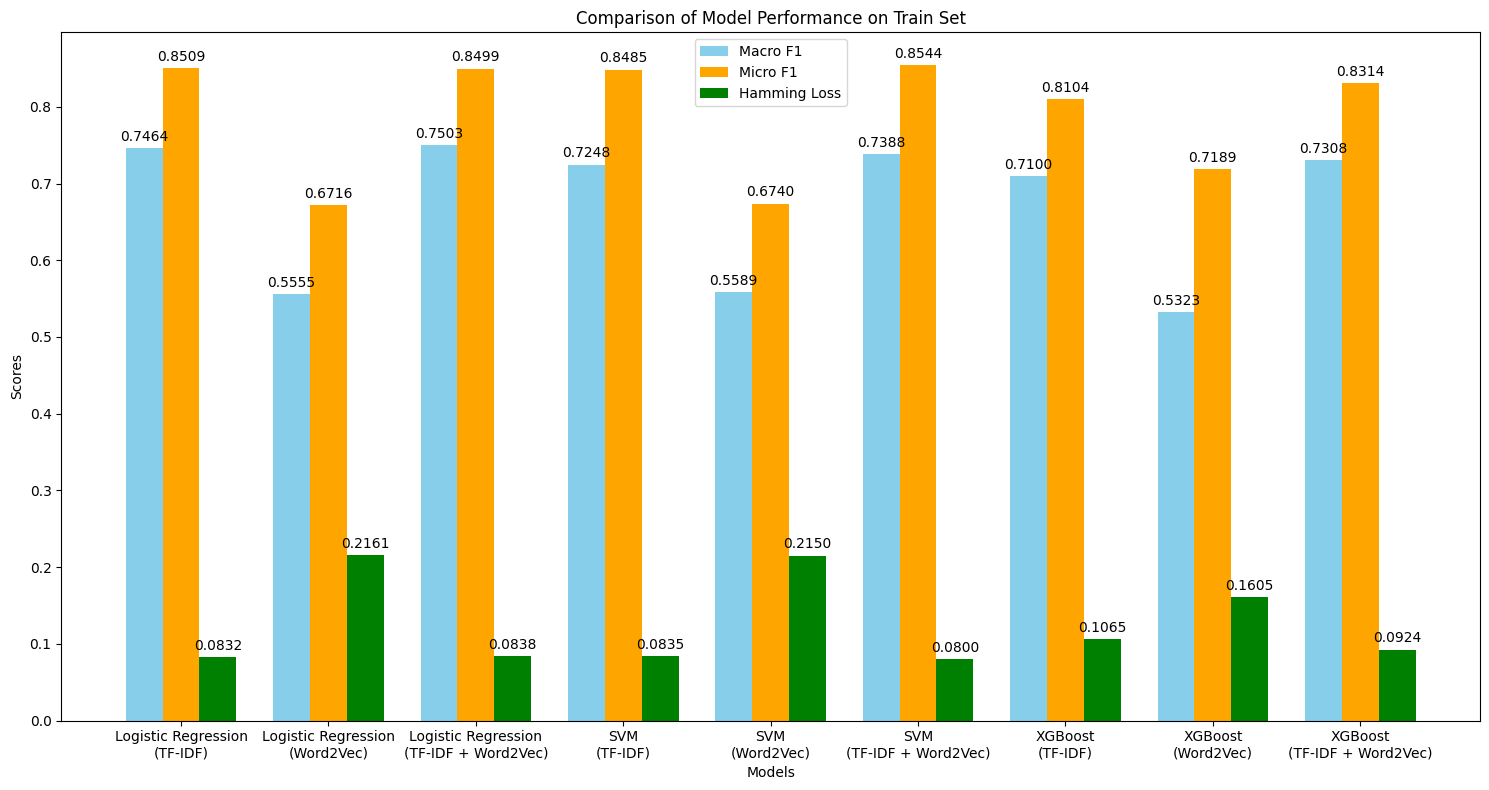

In [ ]:
models = [result['Model'] for result in train_results]
feature_sets = [result['Feature Set'] for result in train_results]
macro_f1 = [result['Macro F1'] for result in train_results]
micro_f1 = [result['Micro F1'] for result in train_results]
hamming_loss = [result['Hamming Loss'] for result in train_results]

x = np.arange(len(models))  
width = 0.25 

fig, ax = plt.subplots(figsize=(15, 8))
bars1 = ax.bar(x - width, macro_f1, width, label='Macro F1', color='skyblue')
bars2 = ax.bar(x, micro_f1, width, label='Micro F1', color='orange')
bars3 = ax.bar(x + width, hamming_loss, width, label='Hamming Loss', color='green')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance on Train Set')
ax.set_xticks(x)
ax.set_xticklabels([f"{model}\n({feature_set})" for model, feature_set in zip(models, feature_sets)])
ax.legend()

for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

## **Testing**

In [52]:
results = []

X_train_tfidf, X_val_tfidf, X_test_tfidf_bi, _, _ = create_tfidf_features_uni_bi(
    train_data['lemmatized_reviews'],
    val_data['lemmatized_reviews'],
    test_data['lemmatized_reviews'],
    min_df=1,
    max_features=5000
)
print("Shape do TF-IDF (train):", X_train_tfidf.shape)
print("Shape do TF-IDF (val):", X_val_tfidf.shape)
print("Shape do TF-IDF (test):", X_test_tfidf_bi.shape)

Feature space size: 5000
Shape do TF-IDF (train): (8002, 5000)
Shape do TF-IDF (val): (994, 5000)
Shape do TF-IDF (test): (1007, 5000)


In [ ]:
X_train_full_tfidf = vstack((X_train_tfidf, X_val_tfidf))

"""print(X_train_tfidf.shape, X_val_tfidf.shape)
print(X_train_full_tfidf.shape)
print(X_train_combined.shape, X_val_combined.shape)"""

y_train_full = np.vstack((y_train, y_val))

X_train_full_combined = np.vstack((X_train_combined, X_val_combined))

In [ ]:
X_test_w2v = np.array([get_w2v_vector(text, w2v_model) for text in test_data['lemmatized_reviews']])

In [ ]:
X_test_combined = combine_tfidf_w2v(X_test_tfidf_bi, X_test_w2v, method="concat")

print("Combined feature shape (test):", X_test_combined.shape)

Combined feature shape (test): (1007, 5300)


### Logistic Regression with Combined TF-IDF + Word2Vec

In [ ]:
from sklearn.metrics import hamming_loss

model_logreg_combined = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced'))

macro_f1, micro_f1, hamming_value, y_pred_logreg_combined = evaluate_model(X_train_full_combined, X_test_combined, y_train_full, y_test, 
               "Logistic Regression (TF-IDF + Word2Vec)", model_logreg_combined)

results.append({
    'Model': 'Logistic Regression',
    'Feature Set': 'Combined TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming_value
})


=== Logistic Regression (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.61      0.99      0.76       311
                OUTROS       0.32      1.00      0.48       236
               PRODUTO       0.99      0.72      0.83       782
CONDICOESDERECEBIMENTO       0.24      1.00      0.39       171
            INADEQUADA       0.29      0.17      0.22        41
               ANUNCIO       0.23      0.97      0.38        87

             micro avg       0.47      0.84      0.61      1628
             macro avg       0.45      0.81      0.51      1628
          weighted avg       0.68      0.84      0.68      1628
           samples avg       0.52      0.86      0.61      1628

Macro F1: 0.5098
Micro F1: 0.6050
Hamming Loss: 0.2954


### SVM

In [ ]:
model_svc = Pipeline([
    ('Linear SVM', OneVsRestClassifier(LinearSVC(max_iter=1000, random_state=42, class_weight='balanced')))
])

macro_f1, micro_f1, hamming, y_pred_svm_combined = evaluate_model(
    X_train_full_combined,  
    X_test_combined,    
    y_train_full,
    y_test,
    "SVM (Pipeline-Combined TF-IDF + Word2Vec)",
    model_svc
)

results.append({
    'Model': 'SVM',
    'Feature Set': 'Combined TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== SVM (Pipeline-Combined TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.59      0.98      0.74       311
                OUTROS       0.35      0.96      0.51       236
               PRODUTO       0.95      0.87      0.91       782
CONDICOESDERECEBIMENTO       0.25      0.98      0.40       171
            INADEQUADA       0.18      0.07      0.10        41
               ANUNCIO       0.18      0.95      0.30        87

             micro avg       0.48      0.90      0.63      1628
             macro avg       0.42      0.80      0.49      1628
          weighted avg       0.66      0.90      0.71      1628
           samples avg       0.52      0.92      0.63      1628

Macro F1: 0.4933
Micro F1: 0.6280
Hamming Loss: 0.2868


### XGBoost

* TF-IDF

In [ ]:
from sklearn.metrics import hamming_loss

scale_pos_weights_full = compute_scale_pos_weight(y_train_full)

model_xgb_tfidf = CustomXGBClassifier(scale_pos_weights=scale_pos_weights_full)

"""# Evaluate the model on the test set
macro_f1, micro_f1, hamming, y_pred_xgb_tfidf = evaluate_model(
    X_train_full_tfidf,  
    X_test_tfidf_bi,     
    y_train_full,
    y_test,
    "XGBoost (TF-IDF)",
    model_xgb_tfidf
)"""

macro_f1, micro_f1, hamming, y_pred_xgb_tfidf = evaluate_model(
    X_train_full_tfidf,  
    X_test_tfidf_bi,     
    y_train_full,
    y_test,
    "XGBoost (TF-IDF)",
    model_xgb_tfidf
)

results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.94      0.91       311
                OUTROS       0.75      0.73      0.74       236
               PRODUTO       0.94      0.87      0.90       782
CONDICOESDERECEBIMENTO       0.74      0.81      0.77       171
            INADEQUADA       0.10      0.41      0.16        41
               ANUNCIO       0.69      0.85      0.76        87

             micro avg       0.78      0.84      0.81      1628
             macro avg       0.68      0.77      0.71      1628
          weighted avg       0.84      0.84      0.84      1628
           samples avg       0.82      0.86      0.82      1628

Macro F1: 0.7084
Micro F1: 0.8136
Hamming Loss: 0.1043


In [ ]:
from sklearn.metrics import hamming_loss

model_xgb_combined = CustomXGBClassifier(scale_pos_weights=scale_pos_weights_full)

macro_f1, micro_f1, hamming, y_pred_xgb_combined = evaluate_model(
    X_train_full_combined, 
    X_test_combined, 
    y_train_full, 
    y_test, 
    "XGBoost (TF-IDF + Word2Vec)", 
    model_xgb_combined
)


results.append({
    'Model': 'XGBoost',
    'Feature Set': 'TF-IDF + Word2Vec',
    'Macro F1': macro_f1,
    'Micro F1': micro_f1,
    'Hamming Loss': hamming
})


=== XGBoost (TF-IDF + Word2Vec) ===
Relatório de Classificação por Rótulo:
                        precision    recall  f1-score   support

               ENTREGA       0.88      0.87      0.87       311
                OUTROS       0.75      0.61      0.67       236
               PRODUTO       0.85      0.98      0.91       782
CONDICOESDERECEBIMENTO       0.89      0.56      0.68       171
            INADEQUADA       1.00      0.05      0.09        41
               ANUNCIO       0.89      0.62      0.73        87

             micro avg       0.84      0.82      0.83      1628
             macro avg       0.87      0.61      0.66      1628
          weighted avg       0.85      0.82      0.81      1628
           samples avg       0.85      0.85      0.83      1628

Macro F1: 0.6598
Micro F1: 0.8305
Hamming Loss: 0.0899


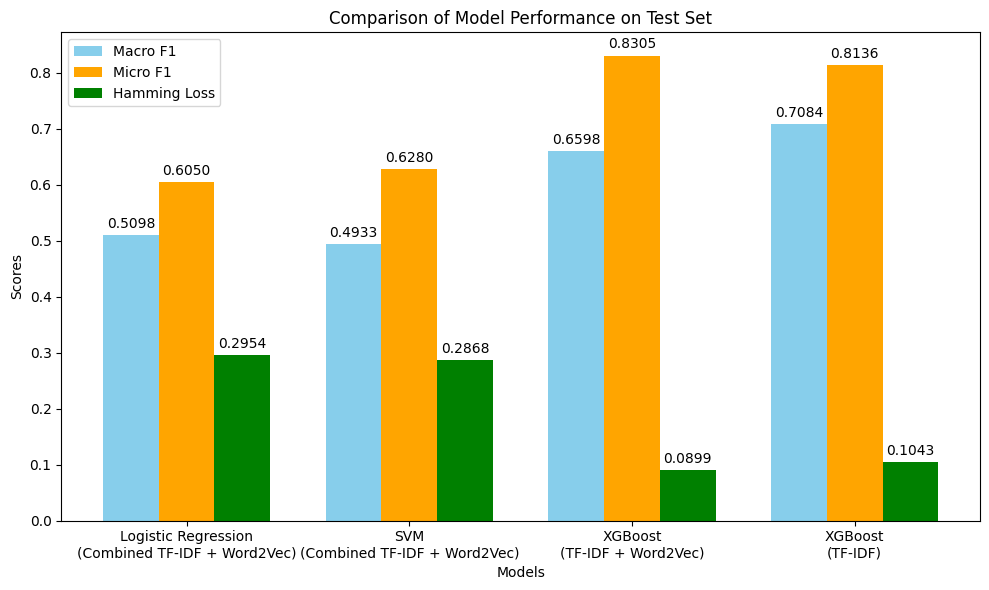

In [ ]:
models = [result['Model'] for result in results]
feature_sets = [result['Feature Set'] for result in results]
macro_f1 = [result['Macro F1'] for result in results]
micro_f1 = [result['Micro F1'] for result in results]
hamming_loss = [result['Hamming Loss'] for result in results]

x = np.arange(len(models))  
width = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, macro_f1, width, label='Macro F1', color='skyblue')
bars2 = ax.bar(x, micro_f1, width, label='Micro F1', color='orange')
bars3 = ax.bar(x + width, hamming_loss, width, label='Hamming Loss', color='green')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance on Test Set')
ax.set_xticks(x)
ax.set_xticklabels([f"{model}\n({feature_set})" for model, feature_set in zip(models, feature_sets)])
ax.legend()

for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

## **Error Analysis**

In [ ]:
def print_confusion_matrices(y_true, y_pred, model_name):
    print(f"\n=== Confusion Matrices for {model_name} ===")
    for i, label in enumerate(label_names):
        y_true_label = y_true[:, i]
        y_pred_label = y_pred[:, i]
        
        cm = confusion_matrix(y_true_label, y_pred_label)
        
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\nLabel: {label}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Negatives (TN): {tn}")

### Logistic Regression

In [ ]:
print_confusion_matrices(y_test, y_pred_logreg_combined, "Logistic Regression (Combined TF-IDF + Word2Vec)")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_logreg_combined, target_names=label_cols))

def analyze_errors(y_true, y_pred, test_data, label_cols):
    for i, label in enumerate(label_cols):
        print(f"\n=== Errors for Label: {label} ===")
        
        false_positives = np.where((y_pred[:, i] == 1) & (y_true[:, i] == 0))[0]
        print(f"False Positives ({len(false_positives)}):")
        for idx in false_positives[:3]:  
            print(f"Review: {test_data['review_text'].iloc[idx]}")
        
        false_negatives = np.where((y_pred[:, i] == 0) & (y_true[:, i] == 1))[0]
        print(f"\nFalse Negatives ({len(false_negatives)}):")
        for idx in false_negatives[:3]:  
            print(f"Review: {test_data['review_text'].iloc[idx]}")

analyze_errors(y_test, y_pred_logreg_combined, test_data, label_cols)


=== Confusion Matrices for Logistic Regression (Combined TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[503 193]
 [  3 308]]
True Positives (TP): 308
False Positives (FP): 193
False Negatives (FN): 3
True Negatives (TN): 503

Label: OUTROS
Confusion Matrix:
[[265 506]
 [  0 236]]
True Positives (TP): 236
False Positives (FP): 506
False Negatives (FN): 0
True Negatives (TN): 265

Label: PRODUTO
Confusion Matrix:
[[219   6]
 [221 561]]
True Positives (TP): 561
False Positives (FP): 6
False Negatives (FN): 221
True Negatives (TN): 219

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[309 527]
 [  0 171]]
True Positives (TP): 171
False Positives (FP): 527
False Negatives (FN): 0
True Negatives (TN): 309

Label: INADEQUADA
Confusion Matrix:
[[949  17]
 [ 34   7]]
True Positives (TP): 7
False Positives (FP): 17
False Negatives (FN): 34
True Negatives (TN): 949

Label: ANUNCIO
Confusion Matrix:
[[645 275]
 [  3  84]]
True Positives (TP): 84
False Positives (FP): 275
False Negati

### SVM

In [ ]:
print_confusion_matrices(y_test, y_pred_svm_combined, "SVM (TF-IDF + Word2Vec)")

print("\n=== Classification Report for SVM ===")
print(classification_report(y_test, y_pred_svm_combined, target_names=label_cols))

print("\n=== Error Analysis for SVM ===")
analyze_errors(y_test, y_pred_svm_combined, test_data, label_cols)



=== Confusion Matrices for SVM (TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[483 213]
 [  6 305]]
True Positives (TP): 305
False Positives (FP): 213
False Negatives (FN): 6
True Negatives (TN): 483

Label: OUTROS
Confusion Matrix:
[[347 424]
 [  9 227]]
True Positives (TP): 227
False Positives (FP): 424
False Negatives (FN): 9
True Negatives (TN): 347

Label: PRODUTO
Confusion Matrix:
[[193  32]
 [105 677]]
True Positives (TP): 677
False Positives (FP): 32
False Negatives (FN): 105
True Negatives (TN): 193

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[326 510]
 [  3 168]]
True Positives (TP): 168
False Positives (FP): 510
False Negatives (FN): 3
True Negatives (TN): 326

Label: INADEQUADA
Confusion Matrix:
[[952  14]
 [ 38   3]]
True Positives (TP): 3
False Positives (FP): 14
False Negatives (FN): 38
True Negatives (TN): 952

Label: ANUNCIO
Confusion Matrix:
[[545 375]
 [  4  83]]
True Positives (TP): 83
False Positives (FP): 375
False Negatives (FN): 4
True Negativ

### XGBoost

In [ ]:
y_pred_xgb_combined = model_xgb_combined.predict(X_test_combined)

print_confusion_matrices(y_test, y_pred_xgb_combined, "XGBoost (TF-IDF + Word2Vec)")

print("\n=== Classification Report for XGBoost ===")
print(classification_report(y_test, y_pred_xgb_combined, target_names=label_cols))


print("\n=== Error Analysis for XGBoost ===")
analyze_errors(y_test, y_pred_xgb_combined, test_data, label_cols)


=== Confusion Matrices for XGBoost (TF-IDF + Word2Vec) ===

Label: ENTREGA
Confusion Matrix:
[[658  38]
 [ 40 271]]
True Positives (TP): 271
False Positives (FP): 38
False Negatives (FN): 40
True Negatives (TN): 658

Label: OUTROS
Confusion Matrix:
[[722  49]
 [ 92 144]]
True Positives (TP): 144
False Positives (FP): 49
False Negatives (FN): 92
True Negatives (TN): 722

Label: PRODUTO
Confusion Matrix:
[[ 86 139]
 [ 18 764]]
True Positives (TP): 764
False Positives (FP): 139
False Negatives (FN): 18
True Negatives (TN): 86

Label: CONDICOESDERECEBIMENTO
Confusion Matrix:
[[824  12]
 [ 76  95]]
True Positives (TP): 95
False Positives (FP): 12
False Negatives (FN): 76
True Negatives (TN): 824

Label: INADEQUADA
Confusion Matrix:
[[966   0]
 [ 39   2]]
True Positives (TP): 2
False Positives (FP): 0
False Negatives (FN): 39
True Negatives (TN): 966

Label: ANUNCIO
Confusion Matrix:
[[913   7]
 [ 33  54]]
True Positives (TP): 54
False Positives (FP): 7
False Negatives (FN): 33
True Negativ